In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import copy
from hendrics.fake import filter_for_deadtime
from stingray import Powerspectrum, Crossspectrum, AveragedPowerspectrum


import numpy as np
import scipy.stats
import scipy.special
import scipy.fftpack

from stingray.utils import rebin_data

np.random.seed(348172694)

from stingray import Lightcurve, Crossspectrum
from stingray.simulator.simulator import Simulator
from scipy.ndimage.filters import gaussian_filter1d


np.random.seed(1209432)

## Real data - that's where we need to get real


In [2]:
from hendrics.io import load_events, load_lcurve, load_pds, save_lcurve, save_pds
from stingray.gti import cross_two_gtis
from stingray import Powerspectrum, Crossspectrum, AveragedPowerspectrum, AveragedCrossspectrum

In [3]:
dt = 1/512

fpma_all = load_events('30001011009A_filt_nustar_fpma_ev.nc')
fpmb_all = load_events('30001011009B_filt_nustar_fpmb_ev.nc')
file_label = 'cygx1_soft_'

In [4]:
tstart = fpma_all.gti[0, 0]
tstop = tstart + 70000

fpma_all.time = fpma_all.time[fpma_all.time < tstop]
fpma_all.gti = fpma_all.gti[fpma_all.gti[:, 1] < tstop]
fpmb_all.time = fpmb_all.time[fpmb_all.time < tstop]
fpmb_all.gti = fpmb_all.gti[fpmb_all.gti[:, 1] < tstop]

In [5]:
# def filt_events(events, factor):
#     nphot = len(events)
#     np.random.shuffle(events)
#     filta = sorted(events[:nphot // factor])
#     return filta

# fpma = copy.deepcopy(fpma_all)
# fpmb = copy.deepcopy(fpmb_all)
fpma = fpma_all
fpmb = fpmb_all
# # Eliminate a LOT of events
# fpma.time = filt_events(fpma.time, 2)
# fpmb.time = filt_events(fpmb.time, 2)


In [6]:
lc1 = fpma.to_lc(dt)
save_lcurve(lc1, 'lc1.nc')
print('LC1 loaded and saved')

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1251-py3.6.egg/stingray/utils.py:60: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


LC1 loaded and saved


In [7]:
lc2 = fpmb.to_lc(dt)
save_lcurve(lc2, 'lc2.nc')
print('LC2 loaded and saved')

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1251-py3.6.egg/stingray/utils.py:60: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


LC2 loaded and saved


In [8]:
from scipy.interpolate import interp1d
from stingray.utils import rebin_data_log
from stingray.gti import bin_intervals_from_gtis
from hendrics.base import r_in, r_det
from fad_correction import *

countrate_ratio = lc1.meanrate / lc2.meanrate
segment_size=512

freqs, pds1_norm, pds2_norm, crosssp_norm, ptot_norm = \
    FAD_power_spectra(lc1, lc2, segment_size)

print('Fourier Amplitudes loaded')

Fourier Amplitudes loaded


In [9]:
pds1_dt = AveragedPowerspectrum(lc1, segment_size=segment_size, norm="frac")
del pds1_dt.cs_all
del pds1_dt.lc1, pds1_dt.lc2
save_pds(pds1_dt, file_label + 'pds1_dt.nc')
del pds1_dt

In [10]:
pds2_dt = AveragedPowerspectrum(lc2, segment_size=segment_size, norm="frac")
del pds2_dt.cs_all
del pds2_dt.lc1, pds2_dt.lc2
save_pds(pds2_dt, file_label + 'pds2_dt.nc')
del pds2_dt

In [11]:
pdstot_norm = load_pds(file_label + 'pds1_dt.nc')

pdstot_norm.norm = 'none'
pdstot_norm.power = ptot_norm
pdstot_norm.power = pdstot_norm.power / pdstot_norm.n**2 
pdstot_norm.power = pdstot_norm.power * 2 * segment_size / (lc1.meancounts + lc2.meancounts) **2

save_pds(pdstot_norm, file_label + 'pdstot_norm.nc')
del pdstot_norm

In [12]:
pds_norm = load_pds(file_label + 'pds1_dt.nc')

pds_norm.norm = 'none'
pds_norm.power = pds1_norm
pds_norm.power = pds_norm.power / pds_norm.n**2 
pds_norm.power = pds_norm.power * 2 * segment_size / lc1.meancounts **2

save_pds(pds_norm, file_label + 'pds_norm.nc')

In [13]:
cs_dt = AveragedCrossspectrum(lc1, lc2, segment_size=segment_size, norm="frac")
del cs_dt.cs_all
del cs_dt.lc1, cs_dt.lc2
del cs_dt.pds1, cs_dt.pds2
save_pds(cs_dt, file_label + 'cs_dt.nc')
del cs_dt

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1251-py3.6.egg/stingray/utils.py:60: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [14]:
cs_norm = load_pds(file_label + 'cs_dt.nc')
cs_norm.norm = 'none'
cs_norm.power = crosssp_norm
cs_norm.power = cs_norm.power / cs_norm.n**2 
cs_norm.power = cs_norm.power * 2 * segment_size / (lc1.meancounts * lc2.meancounts)

save_pds(cs_norm, file_label + 'cs_norm.nc')
del cs_norm

In [15]:
del lc1
del lc2

In [16]:
def load_rebinned(file, rebin_factor, kind='lin'):
    periodogram = load_pds(file)
    if kind == 'lin' and isinstance(rebin_factor, int):
        return periodogram.rebin(f=rebin_factor)
    elif kind == 'lin':
        return periodogram.rebin(df=rebin_factor)
    else:
        return periodogram.rebin_log(rebin_factor)
    
rebin_factor = 1.
cs_dt_reb = load_rebinned(file_label + 'cs_dt.nc', rebin_factor)
cs_norm_reb = load_rebinned(file_label + 'cs_norm.nc', rebin_factor)
pds_norm_reb = load_rebinned(file_label + 'pds_norm.nc', rebin_factor)
pdstot_norm_reb = load_rebinned(file_label + 'pdstot_norm.nc', rebin_factor)
pds1_dt_reb = load_rebinned(file_label + 'pds1_dt.nc', rebin_factor)

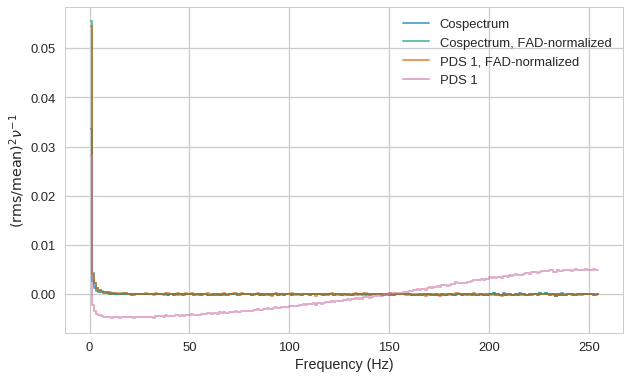

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 6))
# gs = GridSpec(2, 1, hspace=0, height_ratios=(3, 2))
# ax1 = plt.subplot(gs[0])
# ax2 = plt.subplot(gs[1], sharex=ax1)

ax1.plot(cs_dt_reb.freq, cs_dt_reb.power, alpha=0.6, label='Cospectrum', 
         lw=2, drawstyle='steps-mid')

ax1.plot(cs_norm_reb.freq, cs_norm_reb.power, alpha=0.6, label='Cospectrum, FAD-normalized', 
         lw=2, drawstyle='steps-mid')

good = pds_norm_reb.freq > 30

# print(pds_norm.power.real[good], power_norm)
lev = np.mean(pds_norm_reb.power.real[good])
ax1.plot(pds_norm_reb.freq, pds_norm_reb.power - lev, alpha=0.6, label='PDS 1, FAD-normalized', 
         lw=2, drawstyle='steps-mid')

lev = np.mean(pds1_dt_reb.power.real[good])
ax1.plot(pds1_dt_reb.freq, pds1_dt_reb.power - lev, alpha=0.6, label='PDS 1', 
         lw=2, drawstyle='steps-mid')

ax1.legend(loc=1)

# ax1.set_xlim([0.5, 1000])
# ax1.set_ylim([1e-4, None])

ax1.set_xlabel('Frequency (Hz)')

ax1.set_ylabel(r'${(\rm rms/mean)}^2 \nu^{-1}$')
plt.savefig(file_label + 'nustar_2.jpg')

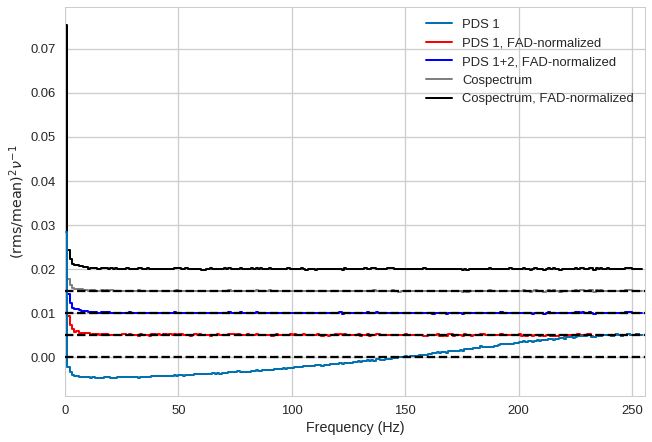

In [18]:
lw=2
step = 0.005
plt.figure()
plt.plot(pds1_dt_reb.freq, pds1_dt_reb.power - np.mean(pds1_dt_reb.power[good]), 
         label='PDS 1', drawstyle='steps-mid', zorder=10, lw=lw)
# plt.plot(pds2_dt.freq, pds2_dt.power, alpha=0.5, label='PDS 2', drawstyle='steps-mid')
plt.plot(pds_norm_reb.freq, pds_norm_reb.power - np.mean(pds_norm_reb.power[good]) + step, 
         label='PDS 1, FAD-normalized', drawstyle='steps-mid', lw=lw, color='r')
plt.plot(pdstot_norm_reb.freq, pdstot_norm_reb.power - np.mean(pdstot_norm_reb.power[good]) + 2*step, 
         label='PDS 1+2, FAD-normalized', drawstyle='steps-mid', lw=lw, color='b')
plt.plot(cs_dt_reb.freq, cs_dt_reb.power + 3 * step, 
         label='Cospectrum', drawstyle='steps-mid', lw=lw, color='grey')
plt.plot(cs_norm_reb.freq, cs_norm_reb.power + 4 * step, 
         label='Cospectrum, FAD-normalized', drawstyle='steps-mid', lw=lw, color='k')
plt.legend(loc=1)

for i in range(4):
    plt.axhline(step * i, ls = '--', color='k', zorder=20)
# plt.ylim([-2 * step, 5 * step])
plt.xlim([0, 256])
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')

plt.savefig(file_label + 'nustar_2_rebin.jpg')

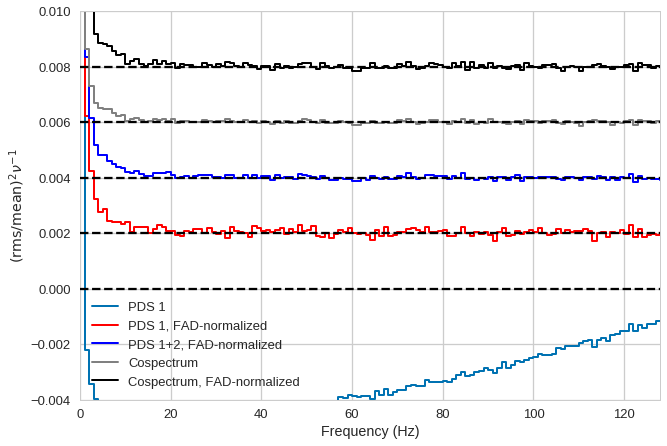

In [19]:
lw=2
step = 0.002
plt.figure()
plt.plot(pds1_dt_reb.freq, pds1_dt_reb.power - np.mean(pds1_dt_reb.power[good]), 
         label='PDS 1', drawstyle='steps-mid', lw=lw)
# plt.plot(pds2_dt.freq, pds2_dt.power, alpha=0.5, label='PDS 2', drawstyle='steps-mid')
plt.plot(pds_norm_reb.freq, pds_norm_reb.power - np.mean(pds_norm_reb.power[good]) + step, 
         label='PDS 1, FAD-normalized', drawstyle='steps-mid', lw=lw, color='r')
plt.plot(pdstot_norm_reb.freq, pdstot_norm_reb.power - np.mean(pdstot_norm_reb.power[good]) + 2*step, 
         label='PDS 1+2, FAD-normalized', drawstyle='steps-mid', lw=lw, color='b')
plt.plot(cs_dt_reb.freq, cs_dt_reb.power + 3 * step, 
         label='Cospectrum', drawstyle='steps-mid', lw=lw, color='grey')
plt.plot(cs_norm_reb.freq, cs_norm_reb.power + 4 * step, 
         label='Cospectrum, FAD-normalized', drawstyle='steps-mid', lw=lw, color='k')
plt.legend()

for i in range(5):
    plt.axhline(step * i, ls = '--', color='k', zorder=20)

plt.ylim([-2 * step, 5 * step])

# plt.arrow(60, 2 * step - step / 10, 0, -step *0.7, fc='k', ec='k', head_width=5, head_length=step * 0.1)
# plt.arrow(50, 2 * step - step / 10, 0, -step *0.7, fc='k', ec='k', head_width=5, head_length=step * 0.1)
# plt.arrow(40, 2 * step - step / 10, 0, -step *0.7, fc='k', ec='k', head_width=5, head_length=step * 0.1)

plt.xlabel('Frequency (Hz)')
plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')

plt.xlim([0, 128])
plt.savefig(file_label + 'nustar_2_rebin_zoom.jpg')

In [20]:
rebin_factor = 0.02
cs_dt_reb_log = load_rebinned(file_label + 'cs_dt.nc', rebin_factor, kind='log')
cs_norm_reb_log = load_rebinned(file_label + 'cs_norm.nc', rebin_factor, kind='log')
pds_norm_reb_log = load_rebinned(file_label + 'pds_norm.nc', rebin_factor, kind='log')
pdstot_norm_reb_log = load_rebinned(file_label + 'pdstot_norm.nc', rebin_factor, kind='log')
pds1_dt_reb_log = load_rebinned(file_label + 'pds1_dt.nc', rebin_factor, kind='log')

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1251-py3.6.egg/stingray/utils.py:231: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y.astype(np.double),
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1251-py3.6.egg/stingray/utils.py:235: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y_err.astype(np.double),
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1251-py3.6.egg/stingray/utils.py:231: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y.astype(np.double),
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1251-py3.6.egg/stingray/utils.py:235: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y_err.astype(np.double),
/home/mbachett/anaconda/envs/py36/lib/python3.6/site

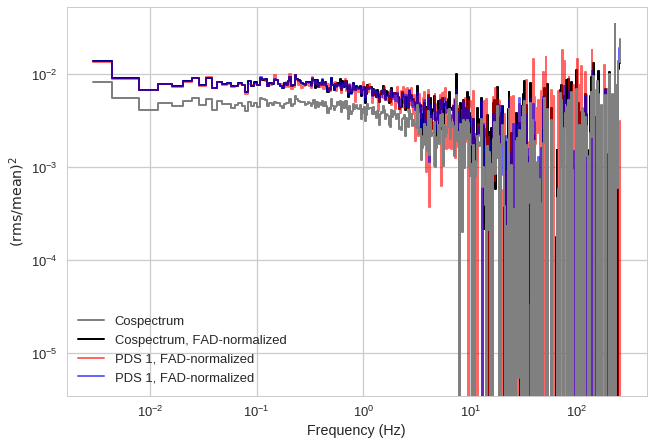

In [21]:
lw=2
fig, ax1 = plt.subplots()

ax1.plot(cs_dt_reb_log.freq, cs_dt_reb_log.freq*cs_dt_reb_log.power, label='Cospectrum', 
         lw=lw, drawstyle='steps-mid', color='grey', zorder=3)

ax1.plot(cs_norm_reb_log.freq, cs_norm_reb_log.freq*cs_norm_reb_log.power, label='Cospectrum, FAD-normalized', 
         lw=lw, drawstyle='steps-mid', color='k')

good = pds_norm_reb_log.freq > 30

lev = np.mean(pds_norm_reb_log.power.real[good])
ax1.plot(pds_norm_reb_log.freq, pds_norm_reb_log.freq*(pds_norm_reb_log.power - lev), alpha=0.6, label='PDS 1, FAD-normalized', 
         lw=lw, drawstyle='steps-mid', color='r')

lev = np.mean(pdstot_norm_reb_log.power.real[good])
ax1.plot(pdstot_norm_reb_log.freq, pdstot_norm_reb_log.freq*(pdstot_norm_reb_log.power - lev), alpha=0.6, label='PDS 1, FAD-normalized', 
         lw=lw, drawstyle='steps-mid', color='b')

ax1.legend()
ax1.set_yscale('log', nonposy='clip')

ax1.set_xscale('log', nonposx='clip')

# ax1.set_xlim([0.005, 100])
# ax1.set_ylim([1e-4, None])

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel(r'${(\rm rms/mean)}^2$')
# ax2.set_ylabel(r'$P_{\rm FAD} - P_{\rm no\,dt}$')
plt.savefig(file_label + 'rednoise_rebin_log.jpg')

In [22]:
rebin_factor = 0.01
cs_dt_reb = load_rebinned(file_label + 'cs_dt.nc', rebin_factor)
cs_norm_reb = load_rebinned(file_label + 'cs_norm.nc', rebin_factor)
pdstot_norm_reb = load_rebinned(file_label + 'pdstot_norm.nc', rebin_factor)
pds_norm_reb = load_rebinned(file_label + 'pds_norm.nc', rebin_factor)
pds1_dt_reb = load_rebinned(file_label + 'pds1_dt.nc', rebin_factor)

In [23]:
from stingray.modeling import fit_powerspectrum
from astropy.modeling.models import Lorentz1D, Const1D, ExponentialCutoffPowerLaw1D, BrokenPowerLaw1D

# model_cs = Lorentz1D(x_0=0.0, fwhm=0.01, amplitude=4) + \
#     Lorentz1D(x_0=0., fwhm=0.2, amplitude=0.15) + \
#     Lorentz1D(x_0=0., fwhm=3, amplitude=0.01)
# model_cs.x_0_0.bounds = [0, 0]
# model_cs.x_0_1.bounds = [0, 0]
# model_cs.x_0_2.bounds = [0, 0]

model_cs = ExponentialCutoffPowerLaw1D(alpha=1, x_cutoff=5, amplitude=0.01, x_0=1)
# model_cs = BrokenPowerLaw1D(alpha_1=1, alpha_2=2, x_break=1, amplitude=0.01)
model_cs.alpha.bounds = [1, 1]
model_cs.x_cutoff.bounds = [5, 5]
model_cs.x_0.bounds = [1, 1]



model_pds = copy.deepcopy(model_cs) + Const1D(0.02)
# model_pds.x_0_0.bounds = [0, 0]
# model_pds.x_0_1.bounds = [0, 0]
# model_pds.x_0_2.bounds = [0, 0]



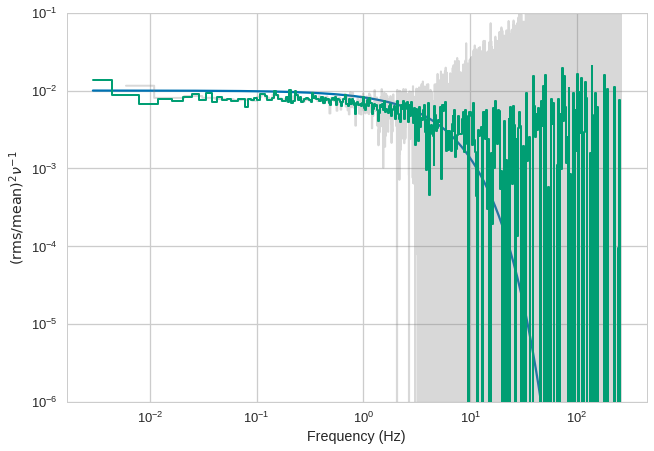

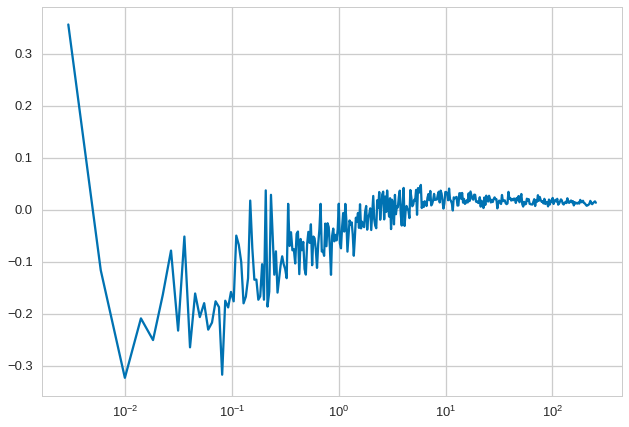

In [24]:
lw=2
plt.figure()
plt.plot(pds_norm_reb_log.freq, pds_norm_reb_log.freq*(model_pds(pds_norm_reb_log.freq) - model_pds.amplitude_1))
good = pds_norm_reb.freq > 30

plt.plot(pds_norm_reb_log.freq, pds_norm_reb_log.freq * (pds_norm_reb_log.power - np.mean(pds_norm_reb.power[good])), 
         label='PDS 1, FAD-normalized', drawstyle='steps-mid', lw=lw, zorder=3)
plt.plot(pds_norm_reb.freq, pds_norm_reb.freq * (pds_norm_reb.power - np.mean(pds_norm_reb.power[good])), 
         color='grey', alpha=0.3, drawstyle='steps-mid', lw=lw)

plt.gca().set_yscale('log', nonposy='clip')

plt.gca().set_xscale('log', nonposx='clip')


plt.xlabel('Frequency (Hz)')
plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')

plt.ylim([1e-6, 1e-1])
plt.figure()
plt.semilogx(pds_norm_reb_log.freq, (pds_norm_reb_log.power - model_pds(pds_norm_reb_log.freq)) / model_pds(pds_norm_reb_log.freq))



In [25]:
from stingray.modeling import ParameterEstimation, GaussianLogLikelihood

good = (cs_dt_reb.freq < 10)&(cs_dt_reb.freq > 0.03)

lpost = GaussianLogLikelihood(cs_dt_reb.freq[good], cs_dt_reb.power[good], 
                              np.sqrt(2/cs_dt_reb.m), copy.deepcopy(model_cs))

cs_dt_parest = ParameterEstimation(fitmethod='L-BFGS-B')
cs_dt_res = cs_dt_parest.fit(lpost, model_cs.parameters)

# cs_dt_parest, cs_dt_res = fit_powerspectrum(cs_dt_reb, copy.deepcopy(model_cs), model_cs.parameters)

In [26]:
good = (cs_norm_reb.freq < 10)&(cs_norm_reb.freq > 0.03)

lpost = GaussianLogLikelihood(cs_norm_reb.freq[good], cs_norm_reb.power[good], 
                              np.sqrt(2/cs_norm_reb.m), copy.deepcopy(model_cs))

cs_norm_parest = ParameterEstimation(fitmethod='L-BFGS-B')
cs_norm_res = cs_norm_parest.fit(lpost, model_cs.parameters)

# cs_norm_parest, cs_norm_res = fit_powerspectrum(cs_norm_reb, copy.deepcopy(model_cs), model_cs.parameters)

In [27]:
good = (pds_norm_reb.freq < 10)&(pds_norm_reb.freq > 0.03)

lpost = GaussianLogLikelihood(pds_norm_reb.freq[good], pds_norm_reb.power[good], 
                              np.sqrt(4/pds_norm_reb.m), copy.deepcopy(model_pds))

pds_norm_parest = ParameterEstimation(fitmethod='L-BFGS-B')
pds_norm_res = pds_norm_parest.fit(lpost, model_pds.parameters)

# pds_norm_parest, pds_norm_res = fit_powerspectrum(pds_norm_reb, copy.deepcopy(model_pds), model_pds.parameters)

In [28]:
good = (pdstot_norm_reb.freq < 10)&(pdstot_norm_reb.freq > 0.03)

lpost = GaussianLogLikelihood(pdstot_norm_reb.freq[good], pdstot_norm_reb.power[good], 
                              np.sqrt(4/pds_norm_reb.m), copy.deepcopy(model_pds))

pdstot_norm_parest = ParameterEstimation(fitmethod='L-BFGS-B')
pdstot_norm_res = pdstot_norm_parest.fit(lpost, model_pds.parameters)

# pds_norm_parest, pds_norm_res = fit_powerspectrum(pds_norm_reb, copy.deepcopy(model_pds), model_pds.parameters)

In [29]:
cs_dt_res.model, cs_norm_res.model, pds_norm_res.model

(<ExponentialCutoffPowerLaw1D(amplitude=0.004904361737201933, x_0=1.0, alpha=1.0, x_cutoff=5.0)>,
 <ExponentialCutoffPowerLaw1D(amplitude=0.008149228821758241, x_0=1.0, alpha=1.0, x_cutoff=5.0)>,
 <CompoundModel0(amplitude_0=0.008021927222447265, x_0_0=1.0, alpha_0=1.0, x_cutoff_0=5.0, amplitude_1=0.020490067029452597)>)

(0.001, 0.1)

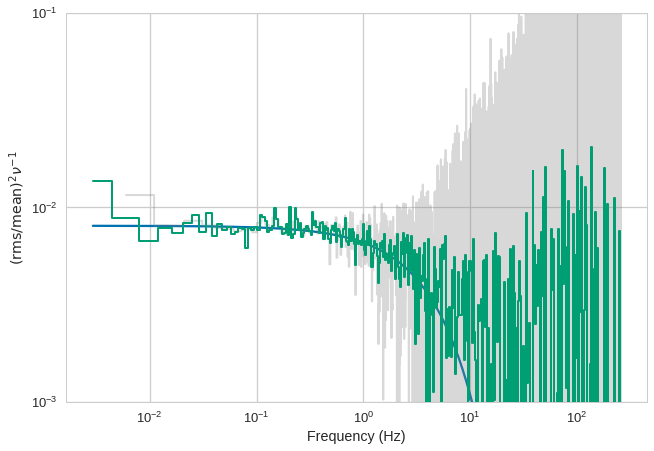

In [30]:
lw=2
plt.figure()
plt.plot(pds_norm_reb_log.freq, pds_norm_reb_log.freq*(pds_norm_res.model(pds_norm_reb_log.freq) - pds_norm_res.model.amplitude_1))
good = pds_norm_reb.freq > 30

plt.plot(pds_norm_reb_log.freq, pds_norm_reb_log.freq * (pds_norm_reb_log.power - np.mean(pds_norm_reb.power[good])), 
         label='PDS 1, FAD-normalized', drawstyle='steps-mid', lw=lw, zorder=3)
plt.plot(pds_norm_reb.freq, pds_norm_reb.freq * (pds_norm_reb.power - np.mean(pds_norm_reb.power[good])), 
         color='grey', alpha=0.3, drawstyle='steps-mid', lw=lw)

plt.gca().set_yscale('log', nonposy='clip')

plt.gca().set_xscale('log', nonposx='clip')


plt.xlabel('Frequency (Hz)')
plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')
plt.ylim([1e-3, 1e-1])


# # plt.savefig('nustar_2_rebin.jpg')
# plt.figure()
# plt.plot(pds_norm_reb_log.freq, 
#          pds_norm_reb_log.freq*(pds_norm_reb_log.power - pds_norm_res.model(pds_norm_reb_log.freq)))


(0.001, 0.1)

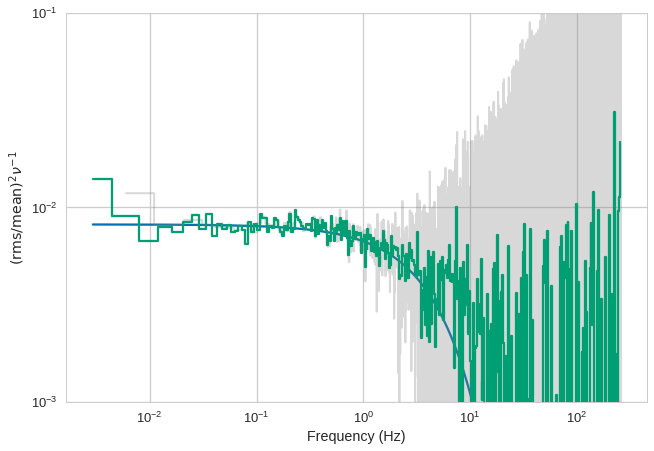

In [31]:
lw=2
plt.figure()
plt.plot(cs_norm_reb_log.freq, cs_norm_reb_log.freq*cs_norm_res.model(cs_norm_reb_log.freq))
good = cs_norm_reb.freq > 30

plt.plot(cs_norm_reb_log.freq, cs_norm_reb_log.freq * (cs_norm_reb_log.power - np.mean(cs_norm_reb.power[good])), 
         label='PDS 1, FAD-normalized', drawstyle='steps-mid', zorder=3)
plt.plot(cs_norm_reb.freq, cs_norm_reb.freq * (cs_norm_reb.power - np.mean(cs_norm_reb.power[good])), 
         color='grey', alpha=0.3, drawstyle='steps-mid', lw=lw)

plt.gca().set_yscale('log', nonposy='clip')

plt.gca().set_xscale('log', nonposx='clip')


plt.xlabel('Frequency (Hz)')
plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')

plt.ylim([1e-3, 1e-1])
# plt.savefig('nustar_2_rebin.jpg')

(0.001, 0.1)

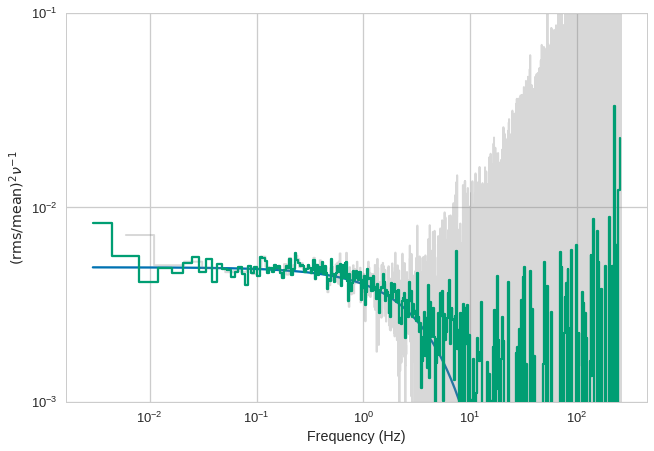

In [32]:
lw=2
plt.figure()
plt.plot(cs_dt_reb_log.freq, cs_dt_reb_log.freq*cs_dt_res.model(cs_dt_reb_log.freq))
good = cs_dt_reb.freq > 30

plt.plot(cs_dt_reb_log.freq, cs_dt_reb_log.freq * (cs_dt_reb_log.power - np.mean(cs_dt_reb.power[good])), 
         label='PDS 1, FAD-normalized', drawstyle='steps-mid', zorder=3)
plt.plot(cs_dt_reb.freq, cs_dt_reb.freq * (cs_dt_reb.power - np.mean(cs_dt_reb.power[good])), 
         color='grey', alpha=0.3, drawstyle='steps-mid', lw=lw)

plt.gca().set_yscale('log', nonposy='clip')

plt.gca().set_xscale('log', nonposx='clip')


plt.xlabel('Frequency (Hz)')
plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')
plt.ylim([1e-3, 1e-1])

# plt.savefig('nustar_2_rebin.jpg')

In [33]:
def model_ratio(model1, model2):
    if hasattr(model1, 'amplitude_0'):
        amp1 = model1.amplitude_0 # + model1.amplitude_1
    else:
        amp1 = model1.amplitude
    if hasattr(model2, 'amplitude_0'):
        amp2 = model2.amplitude_0 # + model1.amplitude_1
    else:
        amp2 = model2.amplitude

    return amp1/amp2

meanrate = pds_norm.nphots/pds_norm.segment_size
expected_gain = r_in(2.5e-3, meanrate)/meanrate

print("rms gain expected from incident/detected "
      "ratio: {:.2f}".format(expected_gain))
gain_cs = model_ratio(cs_norm_res.model, cs_dt_res.model)**0.5
print("rms gain cs_norm/cs_dt: "
      "{:.2f} (correct to {:.1f}%)".format(gain_cs,
                                       (np.abs(gain_cs - expected_gain) / expected_gain) * 100))

gain_pds = model_ratio(pds_norm_res.model, cs_dt_res.model)**0.5
print("rms gain pds_norm/cs_dt: "
      "{:.2f} (correct to {:.1f}%)".format(gain_pds,
                                       (np.abs(gain_pds - expected_gain) / expected_gain) * 100))

gain_pdstot = model_ratio(pdstot_norm_res.model, cs_dt_res.model)**0.5
print("rms gain pdstot_norm/cs_dt: "
      "{:.2f} (correct to {:.1f}%)".format(gain_pdstot,
                                          (np.abs(gain_pdstot - expected_gain) / expected_gain) * 100))


rms gain expected from incident/detected ratio: 1.33
rms gain cs_norm/cs_dt: 1.29 (correct to 3.2%)
rms gain pds_norm/cs_dt: 1.28 (correct to 3.9%)
rms gain pdstot_norm/cs_dt: 1.29 (correct to 3.3%)


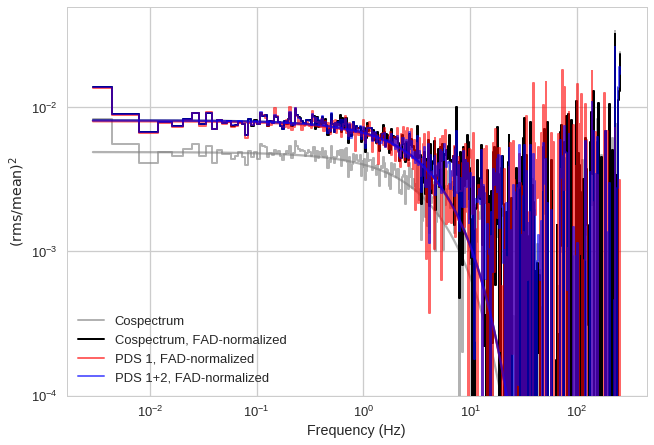

In [34]:
lw=2
fig, ax1 = plt.subplots()

ax1.plot(cs_dt_reb_log.freq, cs_dt_reb_log.freq*cs_dt_reb_log.power, alpha=0.6, label='Cospectrum', 
         lw=lw, drawstyle='steps-mid', color='grey')
ax1.plot(cs_dt_reb_log.freq, cs_dt_reb_log.freq*cs_dt_res.model(cs_dt_reb_log.freq), color='grey', alpha=0.6)

ax1.plot(cs_norm_reb_log.freq, cs_norm_reb_log.freq*cs_norm_reb_log.power, label='Cospectrum, FAD-normalized', 
         lw=lw, drawstyle='steps-mid', color='k')
ax1.plot(cs_norm_reb_log.freq, cs_norm_reb_log.freq*cs_norm_res.model(cs_norm_reb_log.freq), color='k', alpha=0.6)

good = pds_norm_reb_log.freq > 30

lev = np.mean(pds_norm_reb_log.power.real[good])
ax1.plot(pds_norm_reb_log.freq, pds_norm_reb_log.freq*(pds_norm_reb_log.power - lev), 
         alpha=0.6, label='PDS 1, FAD-normalized', 
         lw=lw, drawstyle='steps-mid', color='r')
plt.plot(pds_norm_reb_log.freq, 
         pds_norm_reb_log.freq*(pds_norm_res.model(pds_norm_reb_log.freq) - pds_norm_res.model.amplitude_1),
         alpha=0.6, color='r')

lev = np.mean(pdstot_norm_reb_log.power.real[good])
ax1.plot(pdstot_norm_reb_log.freq, pdstot_norm_reb_log.freq*(pdstot_norm_reb_log.power - lev), 
         alpha=0.6, label='PDS 1+2, FAD-normalized', 
         lw=lw, drawstyle='steps-mid', color='b')
plt.plot(pdstot_norm_reb_log.freq, 
         pdstot_norm_reb_log.freq*(pdstot_norm_res.model(pdstot_norm_reb_log.freq) - pdstot_norm_res.model.amplitude_1),
         alpha=0.6, color='b')


ax1.legend()
ax1.set_yscale('log', nonposy='clip')

ax1.set_xscale('log', nonposx='clip')

# ax1.set_xlim([0.005, 100])
ax1.set_ylim([1e-4, 0.05])

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel(r'${(\rm rms/mean)}^2$')
# ax2.set_ylabel(r'$P_{\rm FAD} - P_{\rm no\,dt}$')
plt.savefig(file_label + 'nustar_2_rebin_log.jpg')